# Kuzushiji Character Recognition

## Imports and Configuration
First, we need to import our libraries and set random seeds for when we do our train/test split

In [1]:
# import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
import tensorflow as tf

print(f"tf version {tf.__version__}")

%matplotlib inline
%load_ext autoreload
%autoreload 2


tf version 2.4.1


In [2]:
# reproducibility
np.random.seed(2021)
random.seed(2021)

In [3]:
def pretty_seconds(s):
    t = str(datetime.timedelta(seconds=s)).split(":")
    return f"{t[0]}h {t[1]}m {t[2]}s"

## Dataset
Our dataset (Kuzishiji-49 or KMNIST) already puts our data as numpy arrays, in a compressed `npz` format.

In [4]:
# load compressed numpy arrays
dataset = "k49" # options are k49 or kmnist

# train images
with np.load(f'./datasets/{dataset}-train-imgs.npz') as data:
    X_tr = data['arr_0']

# train labels
with np.load(f'./datasets/{dataset}-train-labels.npz') as data:
    Y_tr = data['arr_0']
    
# validation images
with np.load(f'./datasets/{dataset}-test-imgs.npz') as data:
    X_val = data['arr_0']

# validation labels
with np.load(f'./datasets/{dataset}-test-labels.npz') as data:
    Y_val = data['arr_0']

If we take a look at our labels, we can see that they're just uints, so no need to do any conversions. We are provided with a classmap that maps numbers to unicode characters. We'll load that and make a helpful function to convert a label to a character.

In [5]:
Y_val[:10]

array([19, 23, 10, 31, 26, 12, 24,  9, 24,  8], dtype=uint8)

In [6]:
# create lookup table + conversion function to convert label to UTF-8 char
lookup_df = pd.read_csv(f'./datasets/{dataset}_classmap.csv')
lookup_df = lookup_df[['codepoint', 'char']]

def label_to_char(label):
    return lookup_df.iloc[label]['char']

In [7]:
label_to_char(Y_val[:10])

19    と
23    ね
10    さ
31    み
26    ひ
12    す
24    の
9     こ
24    の
8     け
Name: char, dtype: object

Taking a look at the shapes of our data and the quantity of samples we have:

In [8]:
print("# of training instances:", X_tr.shape[0])
print("# of validation instances:", X_val.shape[0])
print("Total # of instances:", X_tr.shape[0] + X_val.shape[0])
print("\n")
print("Shape of training instance features:", X_tr.shape[1:])
print("Shape of validation instance features:", X_val.shape[1:])

# of training instances: 232365
# of validation instances: 38547
Total # of instances: 270912


Shape of training instance features: (28, 28)
Shape of validation instance features: (28, 28)


We'll also make a helper function to display a given sample

In [9]:
def display_sample(sample, shape=(28,28), figsize=(4,4)):
    reshaped = sample.reshape(shape)
    scaled = sample * 255
    plt.axis('off')
#   plt.figure(figsize=figsize)
    plt.imshow(reshaped, cmap='Greys', interpolation='nearest')

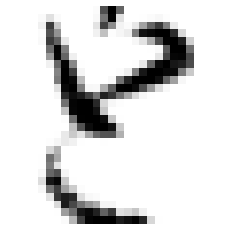

In [10]:
display_sample(X_tr[1])

## Preprocessing

In [11]:
def binarize(sample, threshold=122):
    return np.int8(sample > threshold)

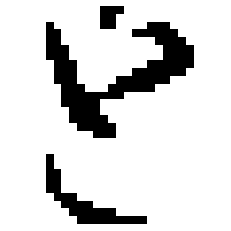

In [12]:
display_sample(binarize(X_tr[1]))

In [13]:
X_tr_bin = binarize(X_tr)
X_val_bin = binarize(X_val)

We need our targets to be one hot encoded for the CNN

In [14]:
Y_tr_onehot = tf.keras.utils.to_categorical(Y_tr)
Y_val_onehot = tf.keras.utils.to_categorical(Y_val)

Let's convert everything to floats instead of ints for the neural network

In [15]:
X_tr_bin = X_tr_bin.astype('float32')
X_val_bin = X_val_bin.astype('float32')
Y_tr_onehot = Y_tr_onehot.astype('float32')
Y_val_onehot = Y_val_onehot.astype('float32')
X_tr = X_tr.astype('float32')
X_val = X_val.astype('float32')
Y_tr = Y_tr.astype('float32')
Y_val = Y_val.astype('float32')

## Neural Network

In [16]:
from tensorflow.keras.layers import Flatten, Dense, Dropout

Let's build the model

In [27]:
model_name = f"neural-{dataset}-{int(time.time())}"
model = tf.keras.models.Sequential([
    Flatten(input_shape=(28,28)),
    Dense(256, activation='relu'),
    Dropout(0.25),
    Dense(256, activation='relu'),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(Y_tr_onehot.shape[1], activation='softmax')
], name=model_name)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

Model: "neural-k49-1633641505"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               200960    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)     

In [28]:
history = model.fit(
    X_tr_bin,
    Y_tr,
    epochs=30,
    batch_size=32,
    validation_data=(X_val_bin, Y_val),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-2, patience=3)
    ]
)

Epoch 1/30
7262/7262 [==============================] - 21s 3ms/step - loss: 1.7965 - accuracy: 0.5364 - val_loss: 1.1019 - val_accuracy: 0.7084
Epoch 2/30
7262/7262 [==============================] - 25s 3ms/step - loss: 0.9621 - accuracy: 0.7505 - val_loss: 0.9764 - val_accuracy: 0.7424
Epoch 3/30
7262/7262 [==============================] - 25s 3ms/step - loss: 0.8531 - accuracy: 0.7786 - val_loss: 0.9287 - val_accuracy: 0.7550
Epoch 4/30
7262/7262 [==============================] - 24s 3ms/step - loss: 0.7990 - accuracy: 0.7931 - val_loss: 0.8884 - val_accuracy: 0.7654
Epoch 5/30
7262/7262 [==============================] - 21s 3ms/step - loss: 0.7632 - accuracy: 0.8021 - val_loss: 0.8860 - val_accuracy: 0.7708
Epoch 6/30
7262/7262 [==============================] - 21s 3ms/step - loss: 0.7422 - accuracy: 0.8083 - val_loss: 0.8736 - val_accuracy: 0.7757
Epoch 7/30
7262/7262 [==============================] - 20s 3ms/step - loss: 0.7247 - accuracy: 0.8131 - val_loss: 0.8629 - val_ac

In [29]:
model.evaluate(X_val_bin,  Y_val, verbose=1)

1205/1205 [==============================] - 2s 1ms/step - loss: 0.8338 - accuracy: 0.8013


[0.8338074088096619, 0.8013074994087219]

In [30]:
Y_preds = tf.nn.softmax(model.predict(X_val_bin)).numpy()
Y_preds[0]

array([0.01971676, 0.01971676, 0.01971676, 0.01971676, 0.01971676,
       0.01971676, 0.01971676, 0.01971676, 0.01971676, 0.01971684,
       0.01971676, 0.01971676, 0.01971676, 0.01971676, 0.01971676,
       0.01971676, 0.01971676, 0.01971676, 0.01971676, 0.05359545,
       0.01971676, 0.01971676, 0.01971676, 0.01971676, 0.01971676,
       0.01971676, 0.01971676, 0.01971676, 0.01971676, 0.01971676,
       0.01971676, 0.01971676, 0.01971676, 0.01971676, 0.01971677,
       0.01971676, 0.01971676, 0.01971676, 0.01971676, 0.01971676,
       0.01971676, 0.01971676, 0.01971676, 0.01971676, 0.01971676,
       0.01971676, 0.01971676, 0.01971676, 0.01971676], dtype=float32)

In [31]:
conf_matrix_df = pd.DataFrame(tf.math.confusion_matrix(Y_val, [np.argmax(y) for y in Y_preds]).numpy(),
             index=[i for i in range(len(lookup_df['char']))],
             columns=[i for i in range(len(lookup_df['char']))]
)

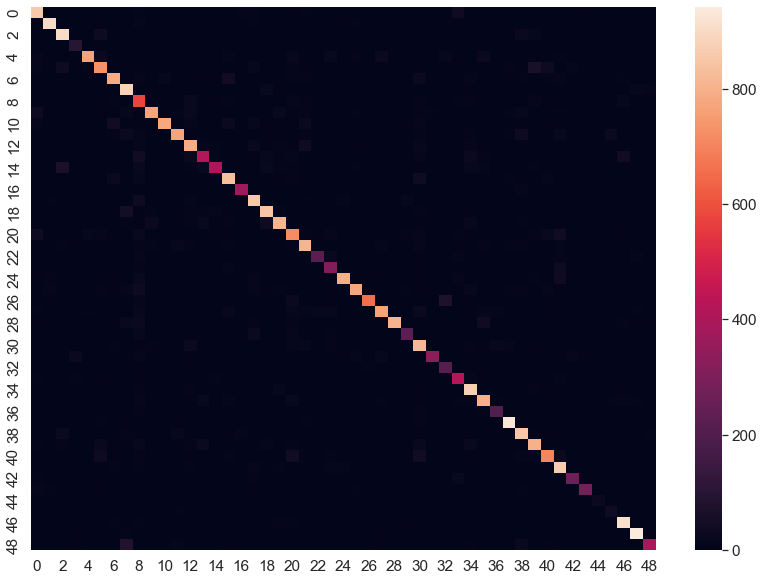

In [32]:
plt.figure(figsize=(14,10))
sns.set(font_scale=1.4)
sns.heatmap(conf_matrix_df, annot=dataset=='kmnist', fmt="g")
plt.show()

In [33]:
model.save(f'models/{model_name}')

INFO:tensorflow:Assets written to: models/neural-k49-1633641505/assets
